In [32]:
%matplotlib inline
import matplotlib.pyplot as plt 
plt.style.use( 'ggplot' ) 

In [33]:
import pandas 
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.cross_validation import cross_val_predict, cross_val_score, StratifiedKFold
import numpy as np 
from scipy.stats import pearsonr

In [34]:
import pickle

In [35]:
# load in the pickled regression problems 

with open( 'combos.pkl', 'rb' ) as fn:
    combos = pickle.load( fn ) 
    
print( len( combos ) ) 

15


Perform 10-fold cross validation using elastic net (runs in < 1 min)

In [36]:
en_preds = []

for nm, target, X, y, support in combos:
    #skf = StratifiedKFold( y, n_folds=10, shuffle=True ) 
    net = ElasticNetCV( cv=10, max_iter=1e9 )
    net.fit( X, y ) 
    preds = net.predict( X )
    score = pearsonr( preds, y ) 
    coefs = list(zip( support, net.coef_ ))
    en_preds.append( ( nm, target, X, y, preds, score, net, coefs ) ) 

Facet the data sets and targets 

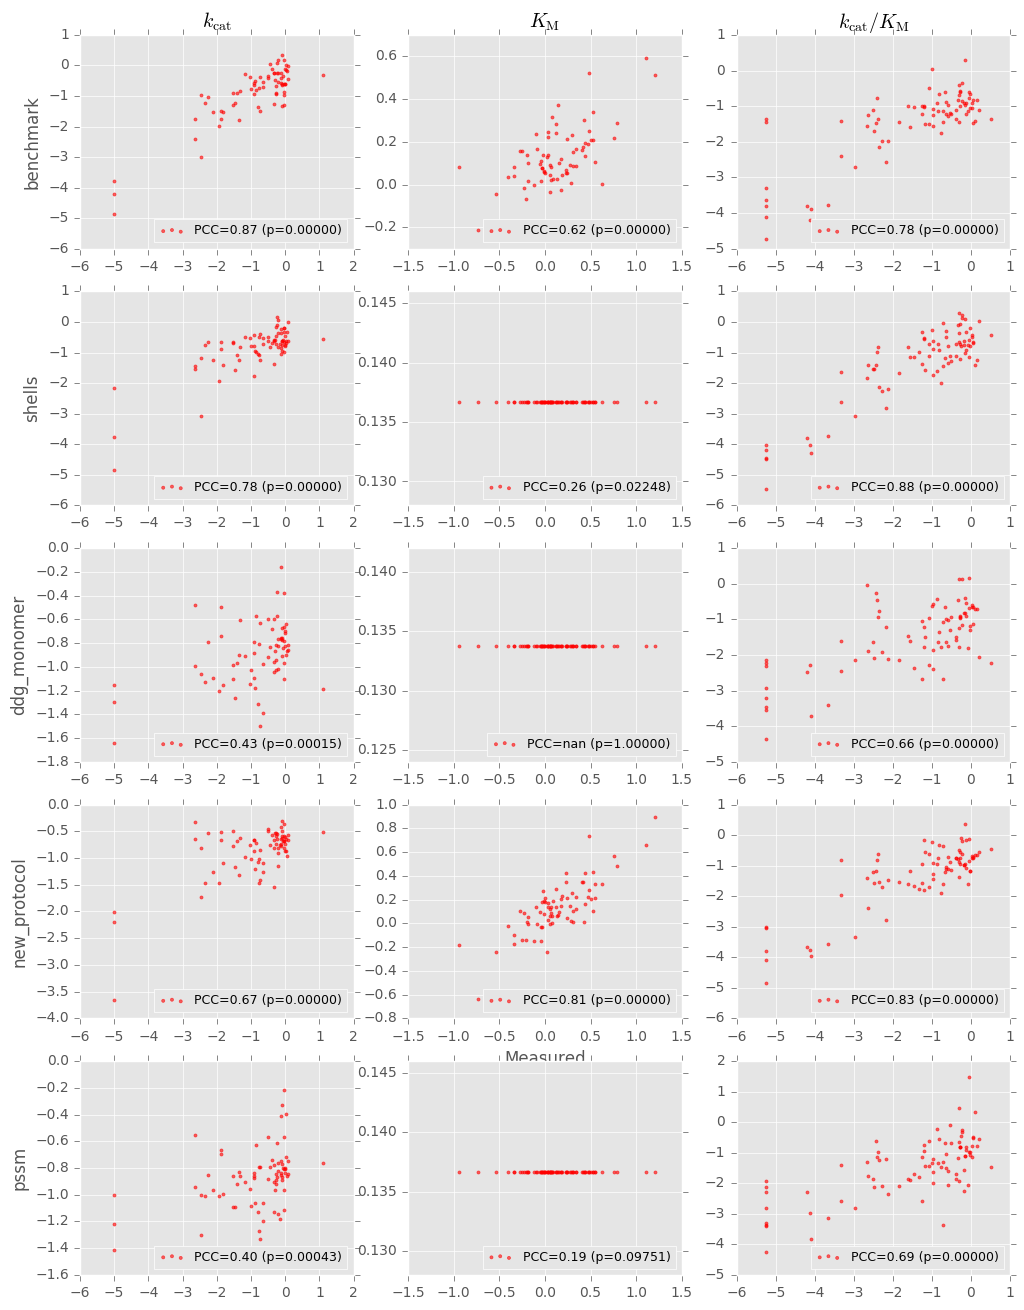

In [37]:
plt.figure( figsize=( 12, 16 ) ) 

for i, ( nm, target, X, y, preds, score, net, coefs ) in enumerate( en_preds ):
    
        plt.subplot( len( combos ) / 3, 3, i+1 )
        
        if i == 0:
            plt.title( '$k_{\mathrm{cat}}$' )
            plt.ylabel( nm ) 
        elif i == 1:
            plt.title( '$K_\mathrm{M}$' )
        elif i == 2:
            plt.title( '$k_{\mathrm{cat}}/K_\mathrm{M}$' ) 
        elif i % 3 == 0:
            plt.ylabel( nm ) 
        elif i == 10:
            plt.xlabel( 'Measured' ) 
        else:
            pass
        
        plt.scatter( y, preds, marker='.', color='red', alpha=.6 )
        plt.legend( [ 'PCC={0:.2f} (p={1:.5f})'.format( *score ) ], loc='lower right', fontsize='9' ) 
        
plt.show()

In [38]:
# feature weights 

for i, ( nm, target, X, y, preds, score, net, coefs ) in enumerate( en_preds ):
    wgts = pandas.DataFrame( coefs, columns=['score_term','weight'] )
    print( nm, target ) 
    print( wgts[ abs( wgts.weight ) > 0.05 ].sort_values( by='weight' ) ) 

benchmark kcat
               score_term    weight
27           SR_2_all_cst -2.468049
46          SR_4_hbond_pm -1.591600
53          SR_5_hbond_sc -1.237272
54           SR_5_all_cst -1.082427
52            SR_5_fa_rep -1.021520
29       SR_2_burunsat_pm -0.997800
15       SR_1_total_score -0.981258
33       SR_3_total_score -0.974402
11  tot_total_pos_charges -0.923135
42       SR_4_total_score -0.661816
4            tot_pstat_pm -0.631426
26          SR_2_hbond_sc -0.592102
10       tot_total_charge -0.574694
47       SR_4_burunsat_pm -0.493471
30          SR_2_pstat_pm -0.481787
9       tot_nlsurfaceE_pm -0.446683
40        SR_3_nlpstat_pm -0.272761
22        SR_1_nlpstat_pm -0.269574
28          SR_2_hbond_pm -0.246858
39          SR_3_pstat_pm -0.179662
21          SR_1_pstat_pm -0.177646
24       SR_2_total_score -0.085950
19          SR_1_hbond_pm  0.111529
37          SR_3_hbond_pm  0.112729
17          SR_1_hbond_sc  0.158598
35          SR_3_hbond_sc  0.168349
12  tot_total

In [39]:
# do the multiple cross-validation 

en_preds = []

for nm, target, X, y, support in combos:
    preds = []
    scores = []
    coefs = []
    for i in range( 10 ):
        skf = StratifiedKFold( y, n_folds=10, shuffle=True ) 
        net = ElasticNetCV( cv=skf, max_iter=1e9 )
        try:
            net.fit( X, y ) 
            preds.append( net.predict( X ) )
            scores.append( net.score( X, y ) )
            coefs.append( list( zip( support, net.coef_ ) ) ) 
        except:
            pass
    en_preds.append( ( nm, target, X, y, preds, score, net, coefs ) ) 

/usr/local/bin/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)
/usr/local/bin/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)
/usr/local/bin/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)
/usr/local/bin/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is to

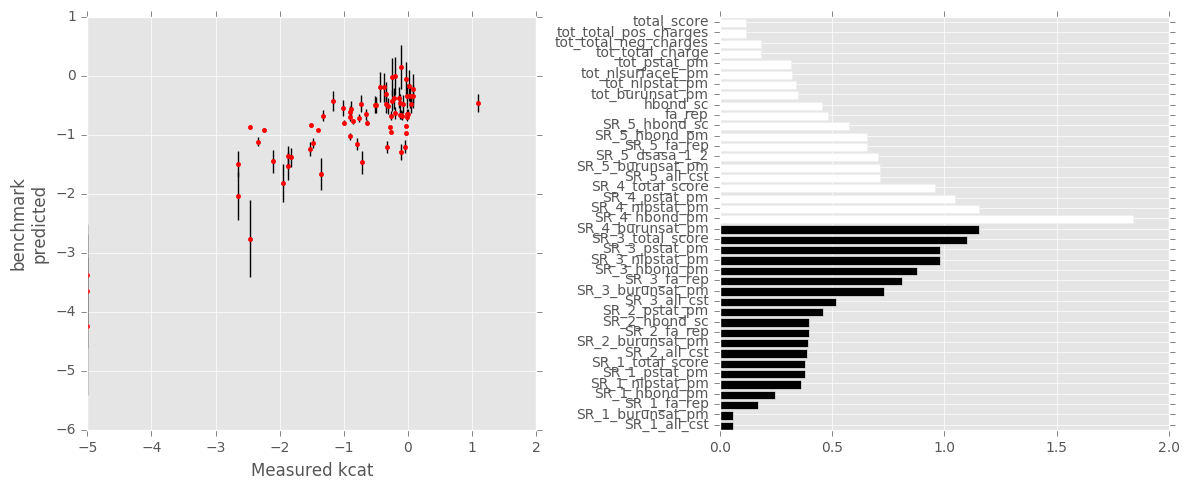

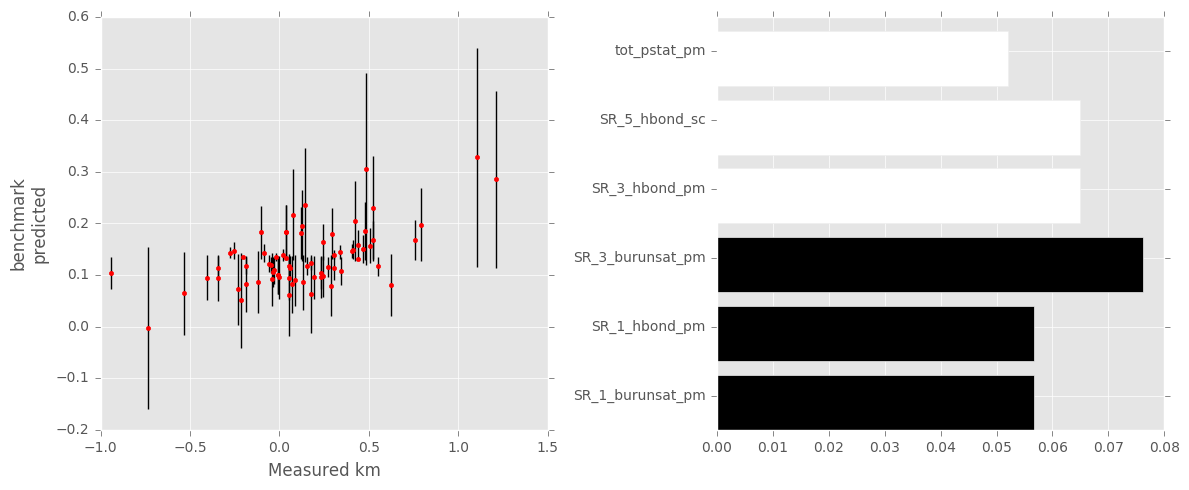

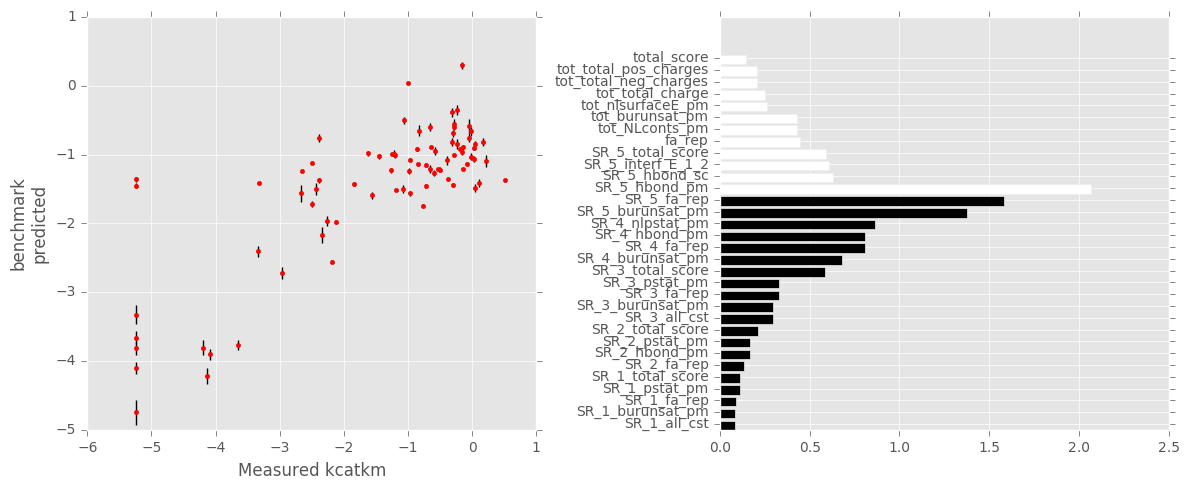

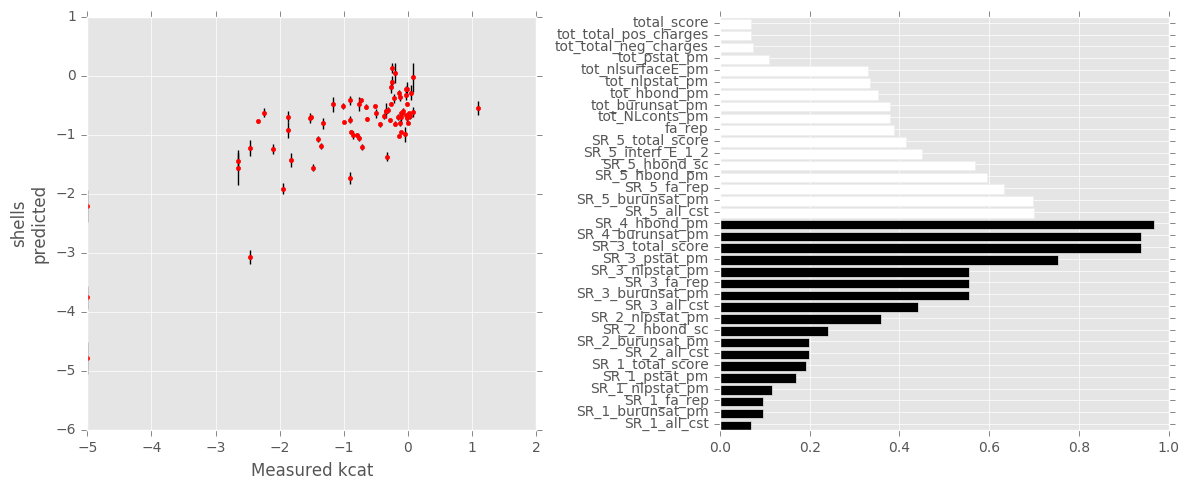

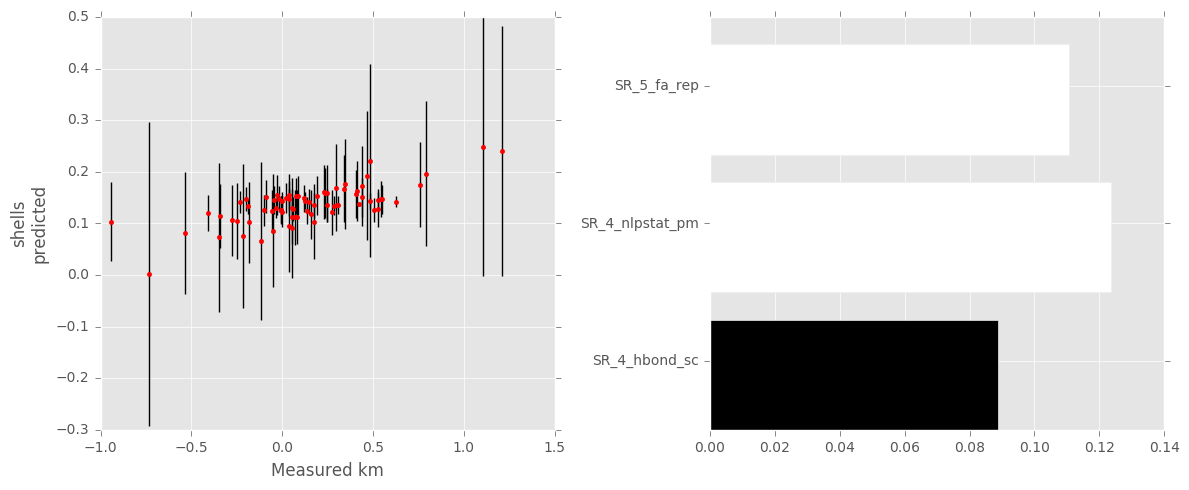

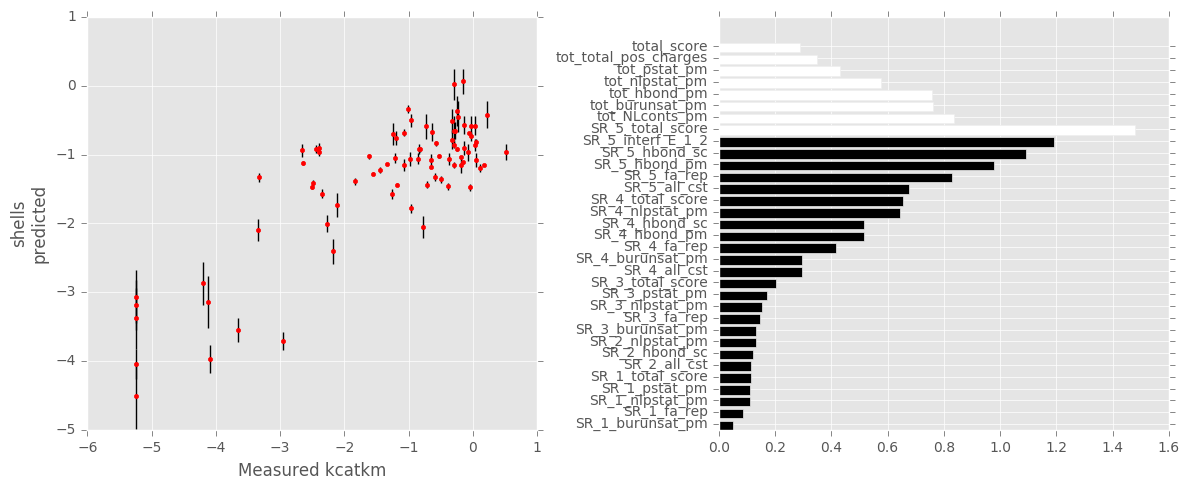

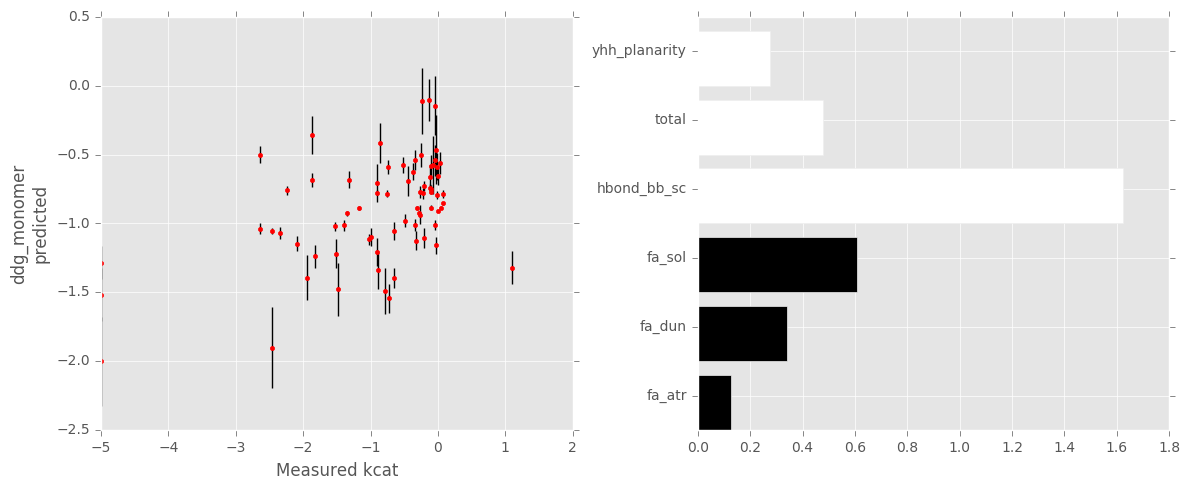

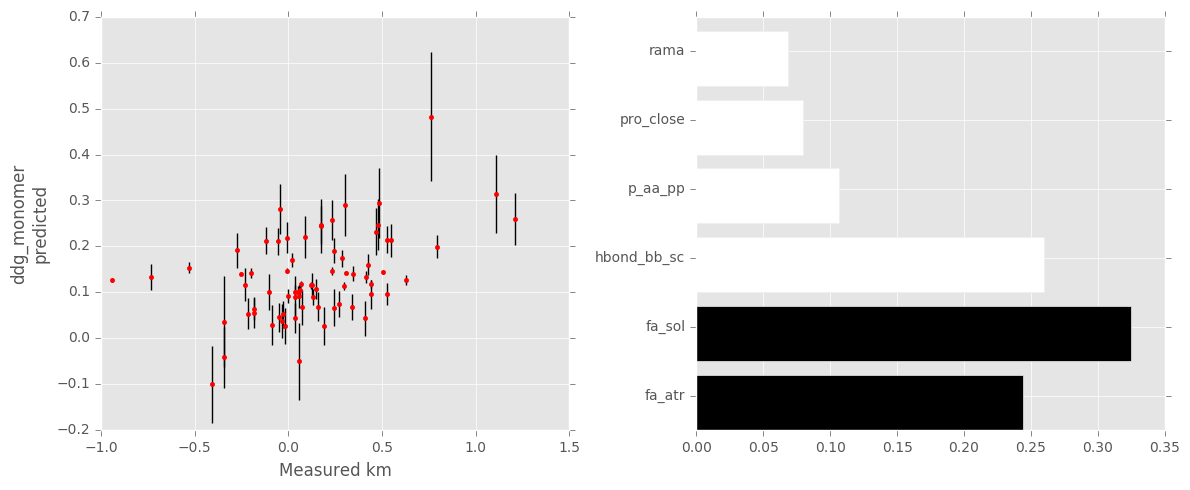

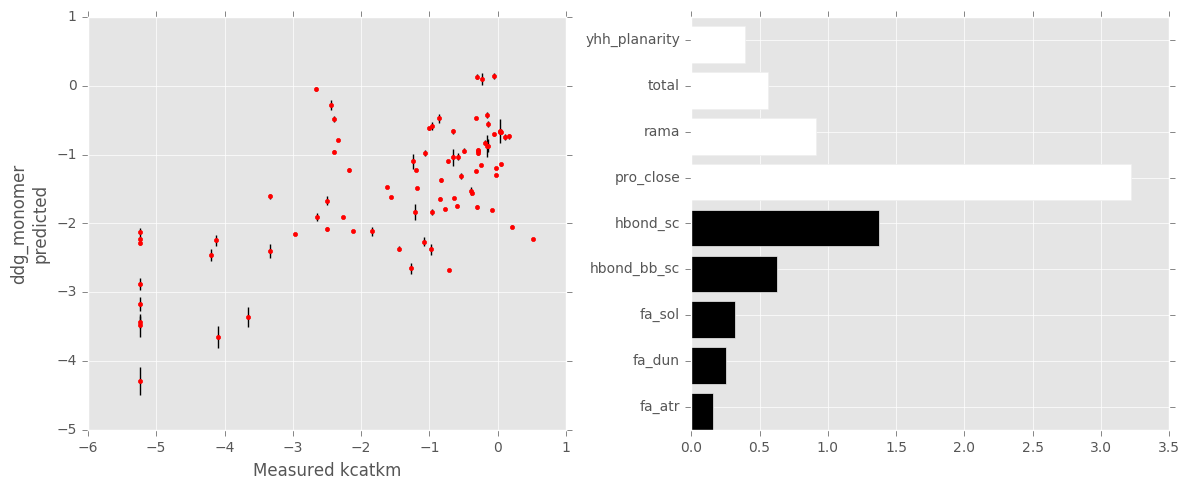

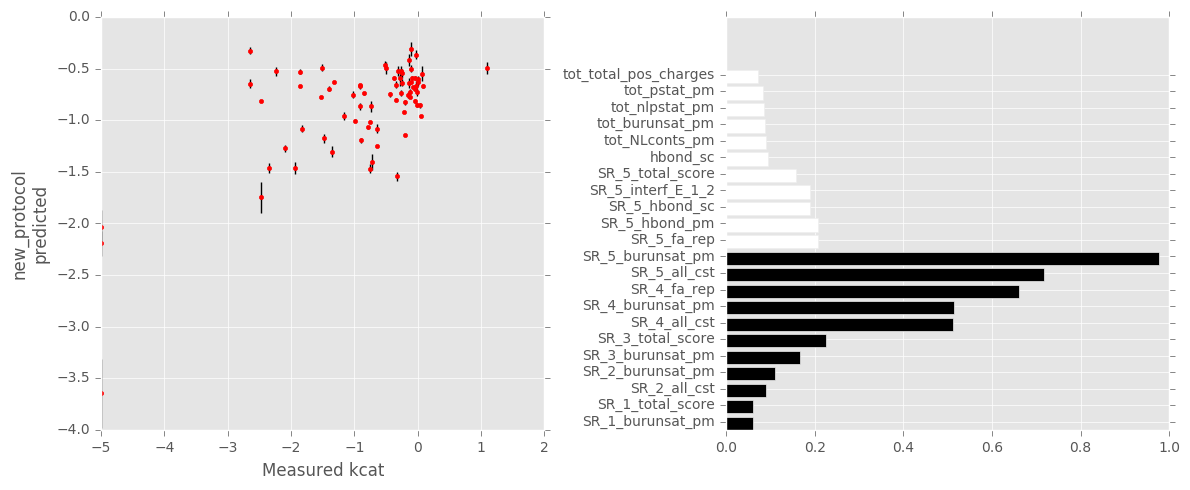

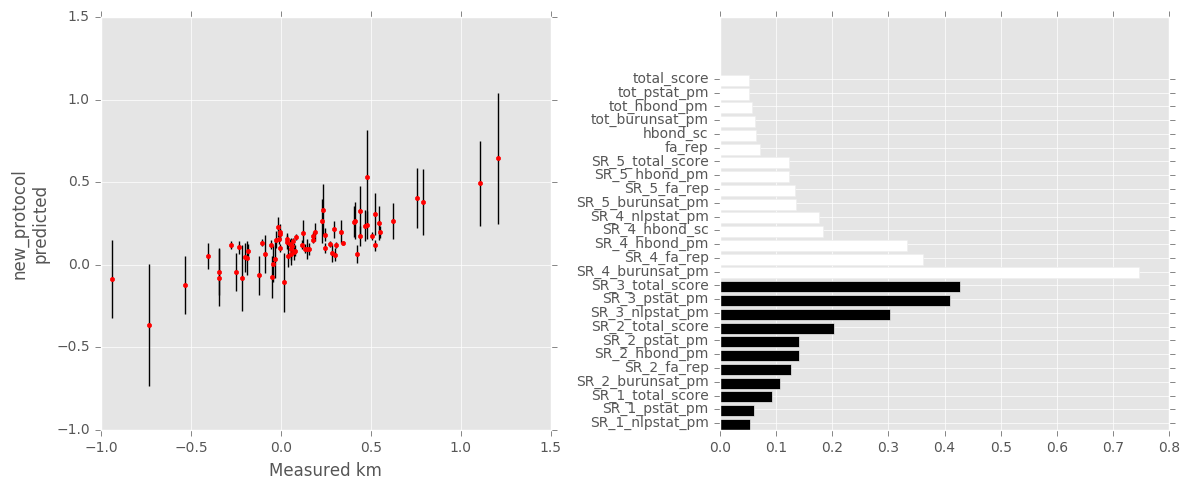

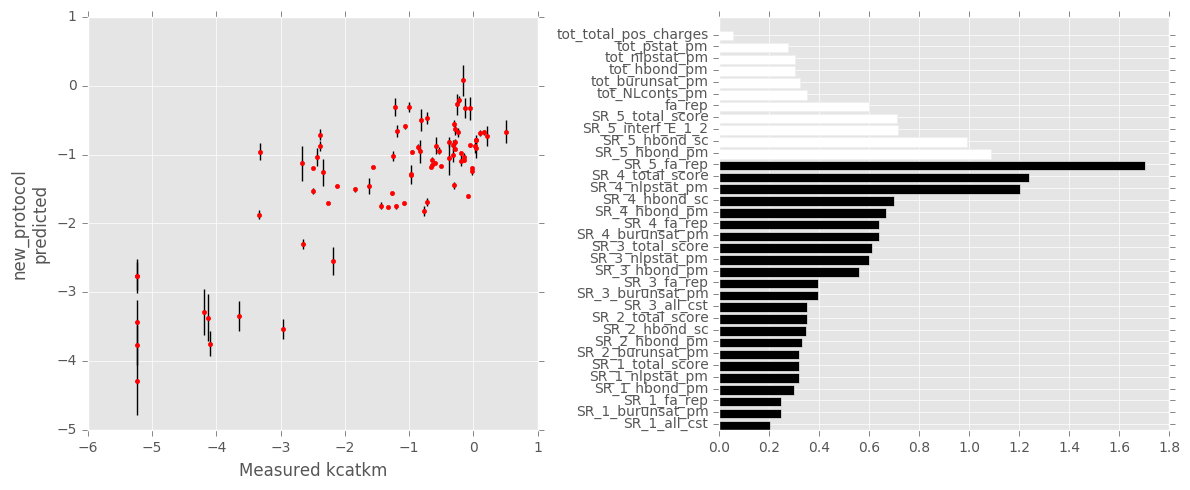

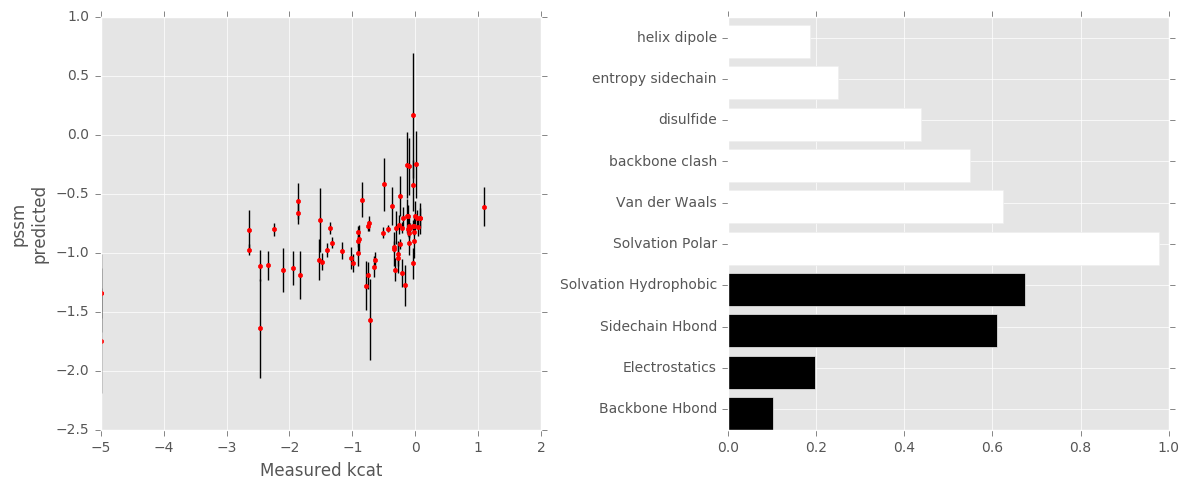

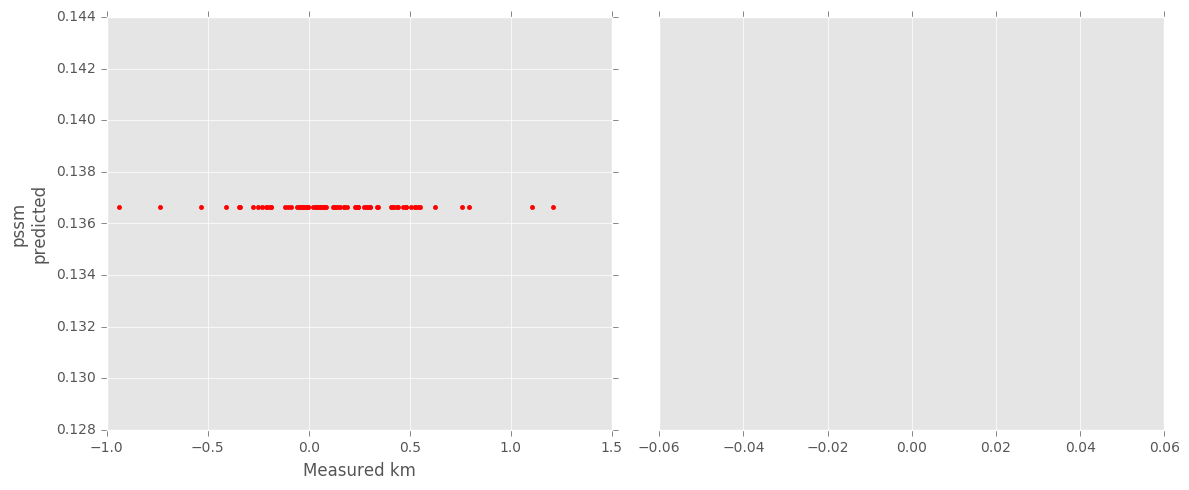

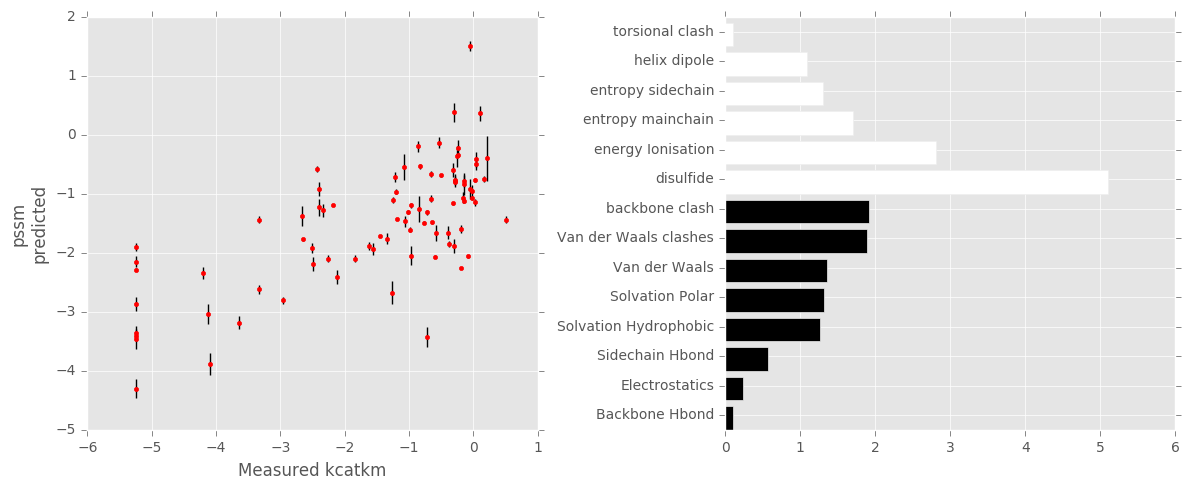

In [40]:
#plt.figure( figsize=( 12, 16 ) ) 

for i, ( nm, target, X, y, preds, score, net, coefs ) in enumerate( en_preds ):
    
        plt.figure( figsize=( 12, 5 ) ) 
        
        mean_predictions = pandas.DataFrame( preds ).mean()
        prediction_err = pandas.DataFrame( preds ).std()
        
        ###
        plt.subplot( 1, 2, 1 ) 
        
        plt.errorbar( y, mean_predictions, yerr=prediction_err, fmt='.',
                      color='red', ecolor='black', capsize=0 )
        plt.xlabel( 'Measured {}'.format( target ) ) 
        plt.ylabel( '{}\npredicted'.format( nm ) ) 
        
        ###
        plt.subplot( 1, 2, 2 ) 
        
        coef_df = pandas.DataFrame( np.concatenate( coefs ), columns=['score','wgt'] ) 
        g = coef_df.groupby( by='score' ).apply( lambda x: pandas.to_numeric( x[ 'wgt' ], errors='coerce' ).mean() ).sort_values() 
        pos = g[ g > 0.05 ] 
        neg = -g[ g < -0.05 ] 

        colors = [ 'black' for i in pos ] + [ 'white' for i in neg ] 
        new_vals = np.concatenate( [ pos, neg ] ) 
        plt.barh( range( len( new_vals ) ), new_vals, color=colors )
        plt.yticks( [ i+0.5 for i in range( len( pos )+len(neg) )], pos.index.union( neg.index ) ) 
                
        plt.tight_layout()
        plt.show()

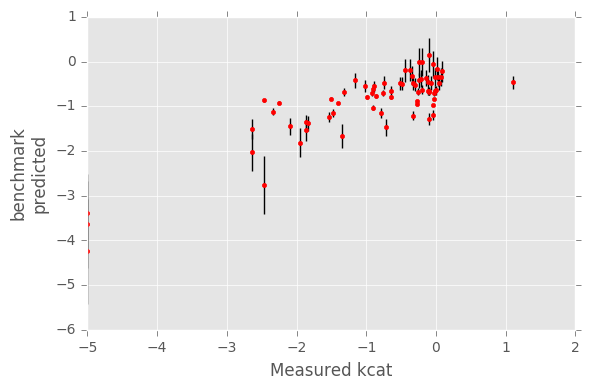

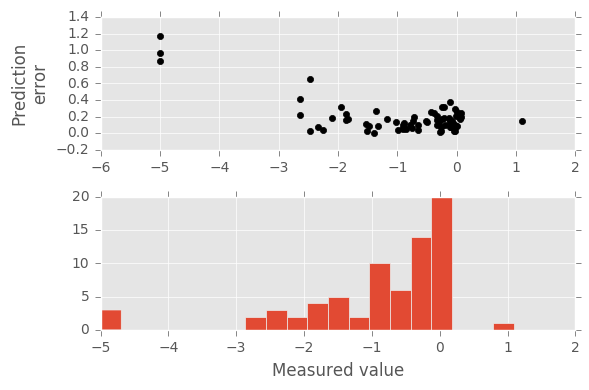

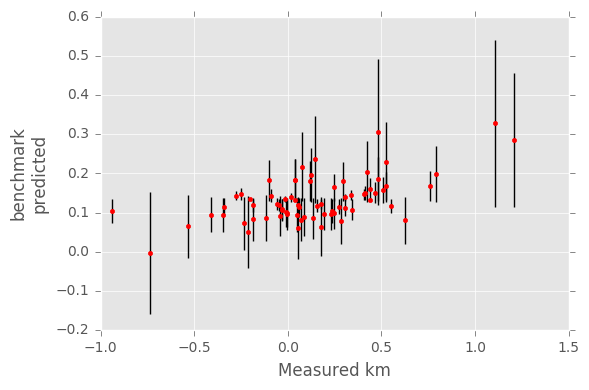

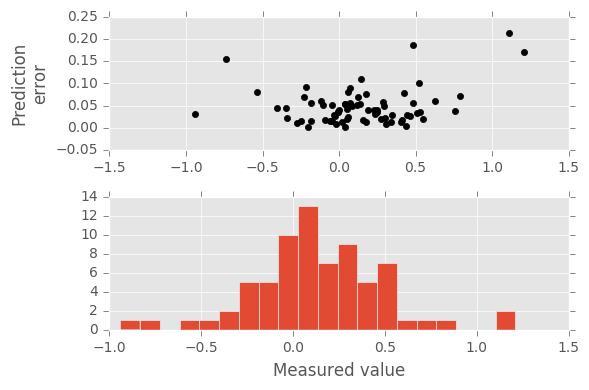

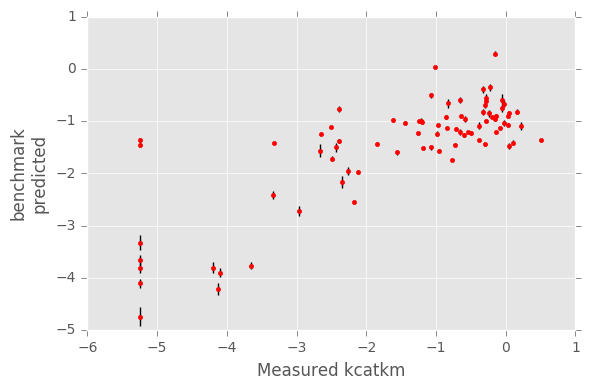

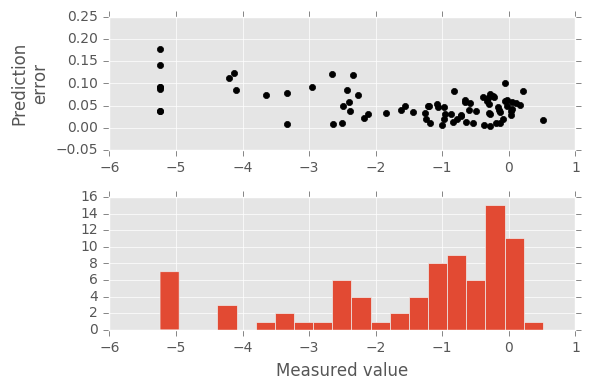

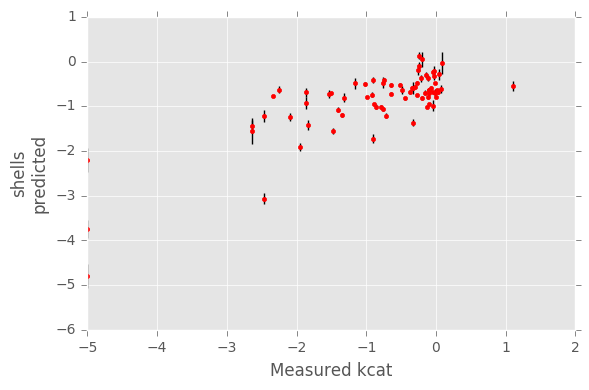

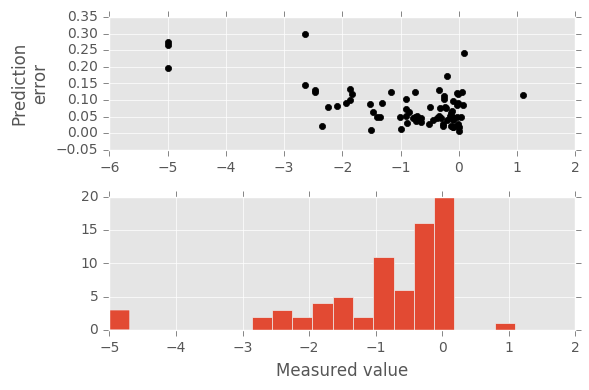

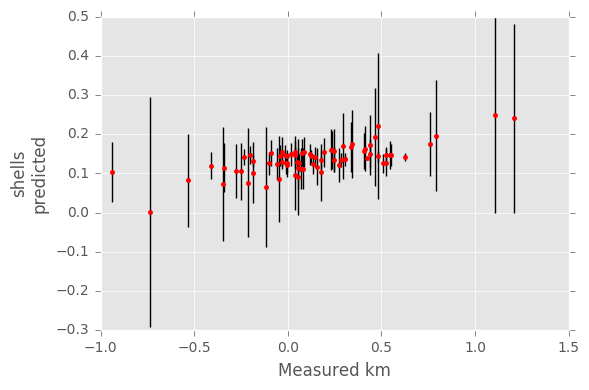

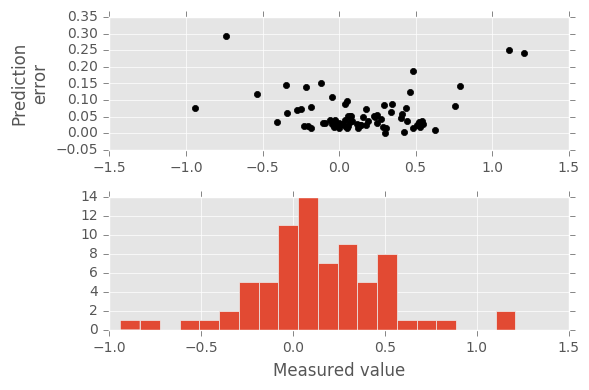

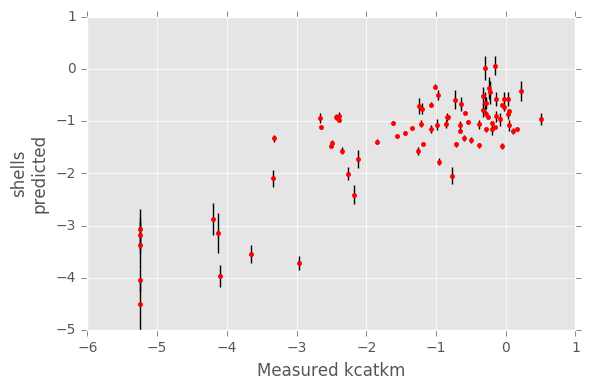

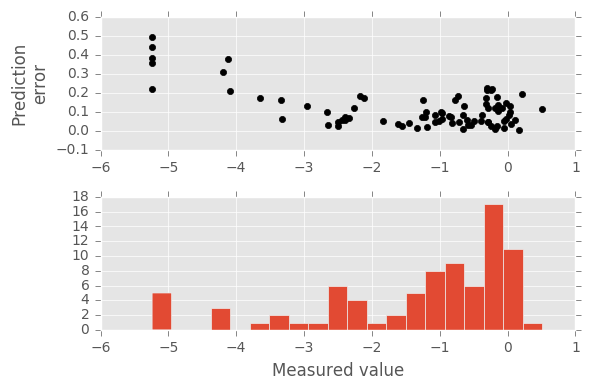

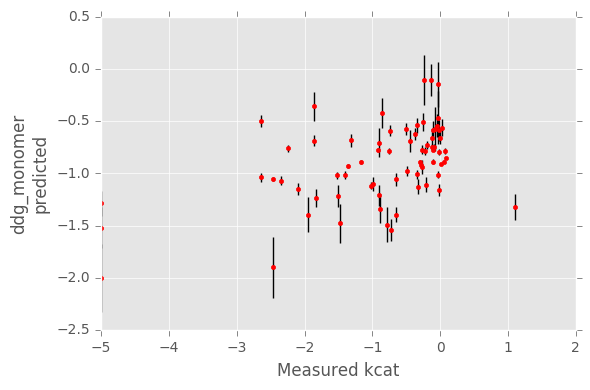

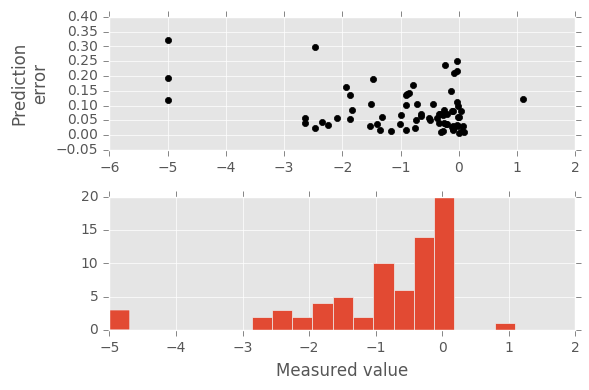

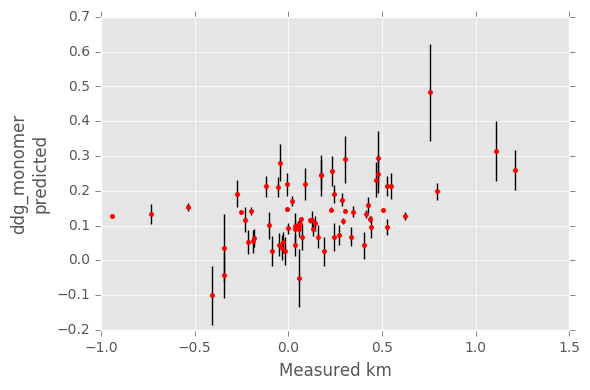

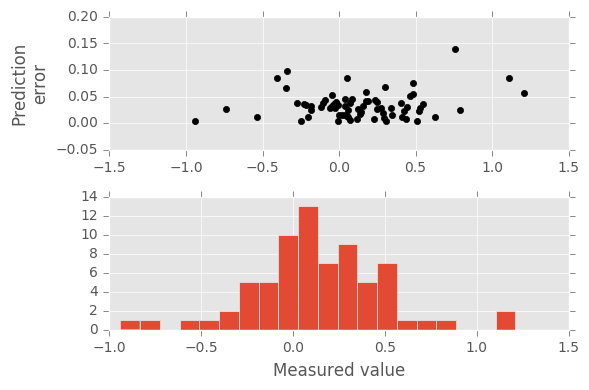

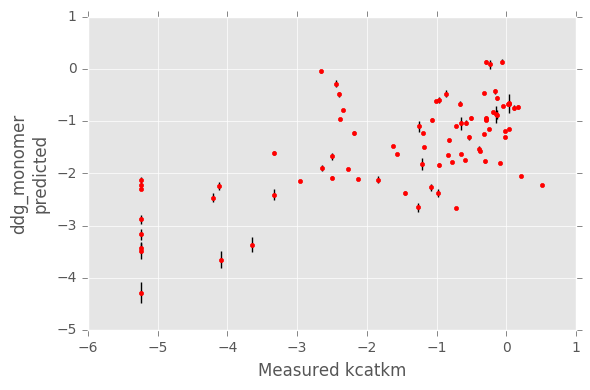

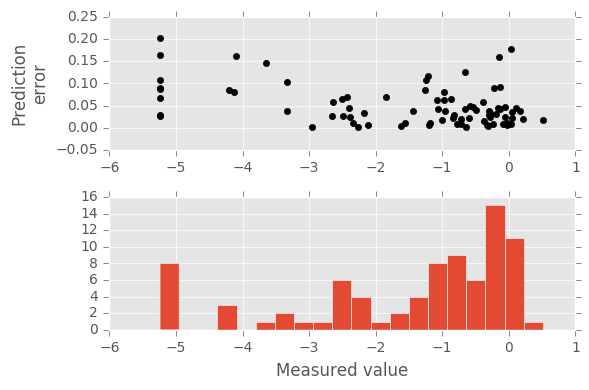

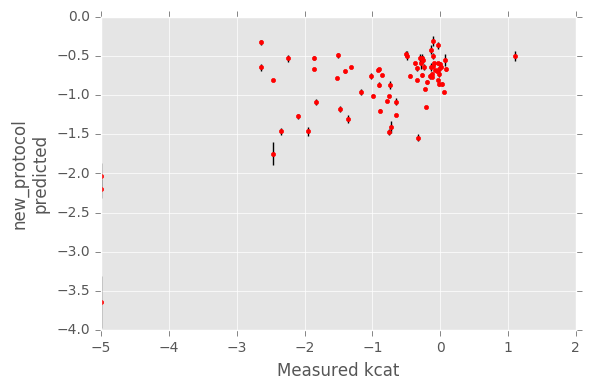

In [ ]:
#plt.figure( figsize=( 12, 16 ) ) 

for i, ( nm, target, X, y, preds, score, net, coefs ) in enumerate( en_preds ):

        # measured versus predicted values 
        plt.figure() 
        
        mean_predictions = pandas.DataFrame( preds ).mean()
        prediction_err = pandas.DataFrame( preds ).std()
        
#         plt.subplot( 1, 2, 1 ) 
        plt.errorbar( y, mean_predictions, yerr=prediction_err, fmt='.', color='red', ecolor='black', capsize=0 )
        plt.xlabel( 'Measured {}'.format( target ) ) 
        plt.ylabel( '{}\npredicted'.format( nm ) ) 
        
#         plt.subplot( 1, 2, 2 ) 
#         coef_df = pandas.DataFrame( np.concatenate( coefs ), columns=['score','wgt'] ) 
#         g = coef_df.groupby( by='score' ).apply( lambda x: pandas.to_numeric( x[ 'wgt' ], errors='coerce' ).mean() ).sort_values() 
#         pos = g[ g > 0.05 ] 
#         neg = -g[ g < -0.05 ] 
#         colors = [ 'magenta' for i in pos ] + [ 'navy' for i in neg ] 
#         new_vals = np.concatenate( [ pos, neg ] ) 
#         plt.barh( range( len( new_vals ) ), new_vals, color=colors )
#         plt.yticks( [ i+0.5 for i in range( len( pos )+len(neg) )], pos.index.union( neg.index ), fontsize=8 ) 
        plt.tight_layout()
        plt.show()        
        
        # prediction error and histogram 
        plt.figure()
        
        plt.subplot( 2, 1, 1 ) 
        plt.scatter( y, prediction_err, color='k' ) 
        plt.ylabel( 'Prediction\nerror' )
        
        plt.subplot( 2, 1, 2 ) 
        plt.hist( y, bins=20 ) 
        plt.xlabel( 'Measured value' )
        #plt.ylabel( 'Frequency' ) 

        plt.tight_layout()
        plt.show()